In [18]:
%matplotlib inline
import os
import re
import copy
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from lxml import etree
import json
import time
import numpy as np

In [59]:
#  truth format is fos \t author author author.....
#  result format is author \t author \t author  .....

In [63]:
# some constant
model = 'bigclam'
link_mode = 'cite'
conference = 'AAAI'
resdir = os.path.join('res', model, link_mode, conference)
pos_tag = 'cmty'
truth_dir = os.path.join('data', link_mode, conference)
measure_result_dir = os.path.join('measure', model, link_mode, conference)
if not os.path.exists(measure_result_dir):
    os.makedirs(measure_result_dir)

In [64]:
def load_r_comm(step):
    comm = []
    filename = os.path.join(resdir, '%s.%s.txt' % (step, pos_tag))
    f = open(filename, 'r')
    for i, line in enumerate(f):
        comm.append(set())
        tpls = line.split('\t')[:-1]
        for tpl in tpls:
            au = tpl.split(',')[0]
            comm[i].add(au)
    return comm

In [65]:
res_comm = load_r_comm('final')

(array([ 75.,   7.,   4.,   3.,   2.,   2.,   2.,   1.,   2.,   2.]),
 array([    0. ,   360.2,   720.4,  1080.6,  1440.8,  1801. ,  2161.2,
         2521.4,  2881.6,  3241.8,  3602. ]),
 <a list of 10 Patch objects>)

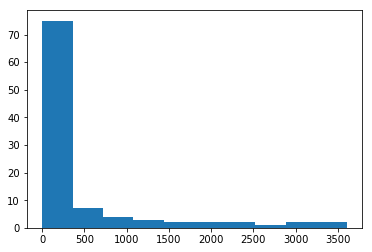

In [66]:
plt.hist(np.array([len(i) for i in res_comm]), bins=10)

In [67]:
def load_t_comm(scope):
    comm = []
    fos_name = []
    filename = os.path.join(truth_dir, 'c_fos_L%d.txt' % scope)
    f = open(filename, 'r')
    for i, line in enumerate(f):
        line = line.strip('\n')
        comm.append(set())
        fos_name = line.split('\t')[0]
        aus = line.split('\t')[1]
        for au in aus.split(' '):
            comm[i].add(au)
    return comm, fos_name
        

In [68]:
truth_comm_scopes = []
truth_comm_scopes_name = []
for i in range(4):
    comm, fos_name = load_t_comm(i)
    truth_comm_scopes.append(comm)
    truth_comm_scopes_name.append(fos_name)

In [78]:
def precision(r, t):
    # r, t a set of authors
    # r-predict t -ruth
    # r & t TP
    # r - r & t FP
    # t - r & t TN
    # precision = tp/(tp+fp)
    if len(r) == 0:
        return 0
    return len(r&t)/(len(r))

In [79]:
def recall(r, t):
    if len(t) == 0:
        return 0
    return len(r&t)/(len(t))

In [80]:
def f1(r, t):
    pre = precision(r, t)
    rec = recall(r, t)
    if pre+rec < 1e-8:
        return 0
    return 2*(pre*rec)/(pre+rec)

In [81]:
def find_bestmatch_f1(xset, ycomm):
    best_score = -1
    for yset in ycomm:
        score = f1(xset, yset)
        if score > best_score:
            best_score = score
    return best_score

In [82]:
def measure(rcomm, tcomm):
    sum1 = 0
    sum2 = 0
    for rset in rcomm:
        sum1 += find_bestmatch_f1(rset, tcomm)
    for tset in tcomm:
        sum2 += find_bestmatch_f1(tset, rcomm)
    return 0.5*(sum1/len(rcomm) + sum2/len(tcomm))

In [83]:
measure_res = []
for i in range(4):
    measure_res.append(measure(res_comm, truth_comm_scopes[i]))

In [84]:
print (measure_res)

[0.17614542695839094, 0.11069418996005398, 0.09150861950720883, 0.08571641553370342]


In [85]:
measure_filename = os.path.join(measure_result_dir, 'res.txt')
mf = open(measure_filename, 'w')
for i in measure_res:
    mf.write('%.5f\n' % i)
mf.close()